In [43]:
# those modules are almost always imported when working with model data
%matplotlib inline
# %matplotlib notebook

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr # the major tool to work with NetCDF data!

import netCDF4
import os
from glob import glob
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import pickle as pickle

## First load Gravity CSV for sampling

In [18]:
import pandas as pd
from glob import glob
def importOIBgrav(basedir, timedir):
    # datadir = 'IGGRV1B/temp'
    # infile = 'IGGRV1B_20091104_13100500_V016'
    # infile = 'IGGRV1B_20091031_11020500_V016'
    # infile = 'IGGRV1B_20091116_15124500_V016'
    suffix = '.txt'
    pattern = os.path.join(basedir, timedir, 'IGGRV1B_20161114_11243000_V017*' + suffix)
    infile = sorted(glob(pattern))  # , key=alphanum_key)

    ### Read ascii file as csv
    # metadata ends on line 69, column names on line 70
    headers = (
        'LAT', 'LONG', 'DATE', 'DOY', 'TIME', 'FLT', 'PSX', 'PSY', 'WGSHGT', 'FX', 'FY', 'FZ', 'EOTGRAV', 'FACOR',
        'INTCOR',
        'FAG070', 'FAG100', 'FAG140', 'FLTENVIRO')
    # print "Reading gravity file: %s" % infile[0] + suffix %TODO why did I think this would be a list?
    print("Reading gravity file: %s" % infile[0] + suffix)
    df = pd.read_csv(infile[0], delimiter=r"\s+", header=None, names=headers, skiprows=70)
    # headers = df.columns[1:df.shape[1]]
    # df.rename(columns=dict(zip(df.columns,headers)), inplace=True)
    # df.rename(columns={'LONG': 'LON'}, inplace=True)
    # df['ENVIRO'] = df.columns[[19]]
    # df.drop(df.columns['FLTENVIRO'],axis=1,inplace=True)

    ### do some DATETIME operations
    df['DATETIME'] = (df.DATE * 1e5) + df.TIME
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
    df['UNIX'] = df['DATE'].astype(np.int64) // 10 ** 9
    df['UNIX'] = df['UNIX'] + df['TIME']
    df['iunix'] = pd.to_datetime(df['UNIX'] * 10 ** 3, unit='ms')
    df.drop(['DATETIME'], axis=1, inplace=True)
    df = df.set_index('iunix')
    return df

basedir = '/Users/dporter/Documents/data_local/Antarctica/OIB/'
datadir = 'IGGRV1B'
timedir = 2016
# grav = importOIBgrav(os.path.join(basedir, datadir), str(timedir))


## RTOPO

In [8]:
# basedir = '/Users/dporter/Documents/data_local/'
basedir = '/Volumes/BASEQI⁩/⁨data_baseqi⁩/'

datadir = 'Antarctica/DEM/RTOPO2'
suffix = '.nc'
# pattern = os.path.join(basedir, datadir, 'RTopo-2.0.1_1min_aux*' + suffix)
# pattern = os.path.join(basedir, datadir, 'RTopo-2.0.1_30sec_Antarctica_data' + suffix)
pattern = ('/Volumes/BASEQI/data_baseqi/Antarctica/DEM/RTOPO2/RTopo-2.0.1_30sec_Antarctica_data.nc')
print(pattern)
filenames = sorted(glob(pattern))  # , key=alphanum_key)
print(filenames)
rtopo2 = xr.open_dataset(filenames[0])
rtopo2

/Volumes/BASEQI/data_baseqi/Antarctica/DEM/RTOPO2/RTopo-2.0.1_30sec_Antarctica_data.nc
['/Volumes/BASEQI/data_baseqi/Antarctica/DEM/RTOPO2/RTopo-2.0.1_30sec_Antarctica_data.nc']


<xarray.Dataset>
Dimensions:              (latdim: 4801, londim: 43201)
Coordinates:
    lon                  (londim) float32 ...
    lat                  (latdim) float32 ...
Dimensions without coordinates: latdim, londim
Data variables:
    bedrock_topography   (latdim, londim) float32 ...
    ice_base_topography  (latdim, londim) float32 ...
    surface_elevation    (latdim, londim) float32 ...
Attributes:
    Title:        RTopo-2 global topography data set, Antarctic sector
    Author:       Janin Schaffer and Ralph Timmermann
    Institution:  Alfred Wegener Institute, Helmholtz Centre for Polar and Ma...
    Source:       Compilation of several original or gridded data sets
    References:   Schaffer, J., R. Timmermann, J.E. Arndt, S.S. Kristensen C....
    Version:      2.0
    Comment:      Use ncview -no_auto_overlay for a simple and efficient data...

In [9]:
np.shape(rtopo2.lat.values)

(4801,)

In [10]:
def get_closest_RTOPO_cell(file_for_latlon, lat, lon):
    """
    SSIA
    :param file_for_latlon:
    :param lat:
    :param lon:
    :return:
    """
    LAT = file_for_latlon['lat'][:]
    LON = file_for_latlon['lon'][:]
#     print(lat,lon)
    a = abs(LON - lon) + abs(LAT - lat)
    iii, jjj = np.unravel_index(a.argmin(), a.shape)
    return iii, jjj

In [11]:
import time
start_sample = time.time()

grav['test3'] =  np.nan
# test2 = np.full([grav.shape[0], ], np.nan)
lat_sample = np.full([grav.shape[0], ], np.nan)
lon_sample = np.full([grav.shape[0], ], np.nan)
# admap_sub = admap[grav['LONG'].max()+360 > admap['lon']+360][grav['LONG'].min()+360 < admap['lon']+360][grav['LAT'].max() > admap['lat']][grav['LAT'].min() < admap['lat']].describe()


# for i in range(0, grav.shape[0], 50):
# # for i in range(0, 30000, 50):
#     ii, jj = get_closest_RTOPO_cell(rtopo2, grav['LAT'][i], grav['LONG'][i])   
# #     ii = get_closest_ADMAP_cell(admap, grav['LAT'][i], grav['LONG'][i])
# #     ii = (abs(rtopo2['lon'][:] - grav['LONG'][i]) + abs(rtopo2['lat'][:] - grav['LAT'][i])).argmin()
# #     print(ii)
# #     print('ii: {}\njj: {}'.format(ii, jj))
#     lat_sample[i/50] = admap['lat'][ii]
#     lon_sample[i/50] = admap['lon'][ii]
# #     print(lat_sample[i])
# #     test[i] = ds['bouguer_anomaly'].isel(x=jj, y=ii).values

#     grav['test3'].iloc[i] = rtopo2['amask'].isel(londim=jj, latdim=ii).values
# #     grav['test'].iloc[i] = ds['ellipsoidal_height'][ii, jj].values
# #     grav['test3'].iloc[i] = rtopo2['s'][ii]
    
# end_sample = time.time()
# print('Sampling took {} sec'.format(end_sample - start_sample))

NameError: name 'grav' is not defined

In [16]:
rtopo2 = rtopo2.set_index(latdim='lat')
rtopo2 = rtopo2.set_index(londim='lon')
rtopo2

<xarray.Dataset>
Dimensions:              (latdim: 4801, londim: 43201)
Coordinates:
  * latdim               (latdim) float64 -90.0 -89.99 -89.98 ... -50.01 -50.0
  * londim               (londim) float64 -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    bedrock_topography   (latdim, londim) float32 ...
    ice_base_topography  (latdim, londim) float32 ...
    surface_elevation    (latdim, londim) float32 ...
Attributes:
    Title:        RTopo-2 global topography data set, Antarctic sector
    Author:       Janin Schaffer and Ralph Timmermann
    Institution:  Alfred Wegener Institute, Helmholtz Centre for Polar and Ma...
    Source:       Compilation of several original or gridded data sets
    References:   Schaffer, J., R. Timmermann, J.E. Arndt, S.S. Kristensen C....
    Version:      2.0
    Comment:      Use ncview -no_auto_overlay for a simple and efficient data...

Sampling took 2494.81481004 sec

In [17]:
# rtopo2['amask'].sel(latdim=[-79], method='nearest').values
# rtopo2.where(rtopo2.lat==-79, drop=True)
rtopo2.sel(latdim=[-70,-71,-72, -73, -74, -75, -76, -77, -78, -79,-80,-81,-82], 
           londim=[0,1,2,3,4,5,6,7,8,9,10,11,12])['bedrock_topography'].values.diagonal()

array([-483.7342  , -324.2308  ,   69.08606 , 1160.8523  ,  809.06775 ,
        789.07965 ,  330.3528  ,  336.65903 ,    8.152774,  109.84514 ,
        231.11136 ,  -32.514244, -514.73737 ], dtype=float32)

In [41]:
start_sample = time.time()

grav['RTOPO2'] = np.nan
grav['RTOPO2'].iloc[::14] = rtopo2.sel(latdim=grav['LAT'].values[::14], 
           londim=grav['LONG'].values[::14], method='nearest')['bedrock_topography'].values.diagonal()

end_sample = time.time()
print(('Sampling took {} sec'.format(end_sample - start_sample)))

Sampling took 66.65483808517456 sec


/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [42]:
grav['RTOPO2'].interpolate(method='nearest', limit_area='inside', axis=0).unique()

array([36.5 , 36.75, 30.25, ...,  8.  , 20.  ,   nan])

## Read in random lat lons from .csv
here from Renata's seismic points over George IV

In [27]:
df = pd.read_csv('data/seismic_points_latlon.txt', delimiter=r"\s+")
df

,LON,LAT,SEISMIC
0,-68.263667,-70.248500,-637
1,-68.349833,-70.249333,-518
2,-68.430500,-70.251167,-656
3,-68.510333,-70.254167,-561
4,-68.589000,-70.252000,-486
...,...,...,...
96,-70.606833,-72.786167,-849
97,-70.568667,-72.751333,-578
98,-70.453167,-72.720833,-542
99,-70.411500,-72.697667,-654


In [34]:
start_sample = time.time()

df['RTOPO2'] = np.nan
# print(rtopo2.sel(latdim=df['LAT'].values, 
#            londim=df['LON'].values, 
#            method='nearest')['bedrock_topography'].values.diagonal())

df['RTOPO2'] = rtopo2.sel(latdim=df['LAT'].values, 
           londim=df['LON'].values, method='nearest')['bedrock_topography'].values.diagonal()

end_sample = time.time()
print(('Sampling took {} sec'.format(end_sample - start_sample)))

Sampling took 0.16376495361328125 sec


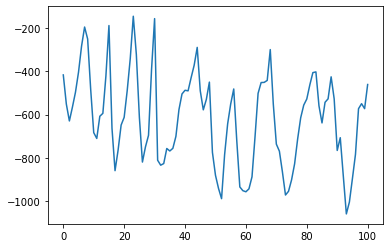

In [44]:
plt.plot(df['RTOPO2'])

In [41]:
df.to_csv('seismic_latlon_rtopo2.csv')

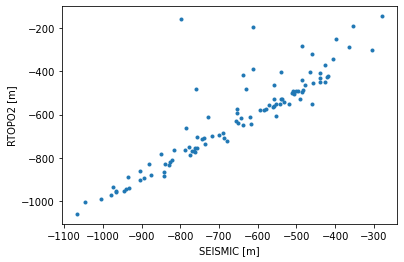

In [52]:
plt.plot(df.SEISMIC, df.RTOPO2, linestyle='', marker='.')
plt.xlabel('SEISMIC [m]')
plt.ylabel('RTOPO2 [m]')
plt.savefig('figs/GeorgeVI_bathymetry_seismic-vs-rtopo2.png')

## Map plot (this is slowwww)

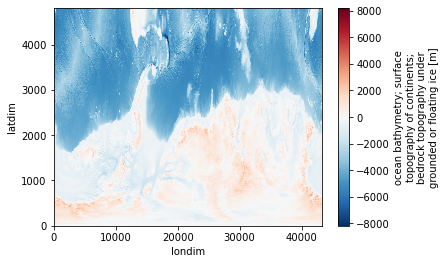

In [12]:
rtopo2['bedrock_topography'].plot()

ValueError: not enough values to unpack (expected 2, got 1)

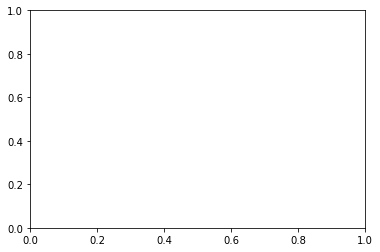

In [151]:
x = xr.DataArray(grav['LONG'].values, dims='z')
y = xr.DataArray(grav['LAT'].values, dims='z')
plt.pcolormesh(rtopo2.sel(londim=x, latdim=y, method='nearest')['amask'])

In [97]:
plt.scatter(grav['LONG'], grav['LAT'], c=np.round(fill_nan(grav['test3'])), marker='s')
plt.colorbar()

NameError: name 'fill_nan' is not defined